In [1]:
import torch 
from hnet.train.hnet import train_hnet
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.calibration import calibration_curve

In [2]:
kiba = pd.read_csv('../../extdata/kiba/kiba.csv')
drugs = pd.read_csv('../../extdata/kiba/drugs.csv')
prots = pd.read_csv('../../extdata/kiba/prots.csv')
z_drug = torch.load('../../extdata/kiba/z_drug.pt').cpu()
z_prot = torch.load('../../extdata/kiba/z_prot.pt').cpu()

/tmp/ipykernel_8928/238337257.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z_drug = torch.load('../../extdata/kiba/z_drug.pt').cpu()
/tmp/ipykernel_8928/238337257.py:

In [3]:
x_drug = z_drug[kiba.drug_idx.values]
x_prot = z_prot[kiba.prot_idx.values]
x = torch.cat([x_drug, x_prot], dim=1)
y = torch.tensor(kiba['Ki , Kd and IC50  (KIBA Score)'].values, dtype=torch.float32).view(-1, 1)
print(x.shape, y.shape)

torch.Size([118254, 1792]) torch.Size([118254, 1])


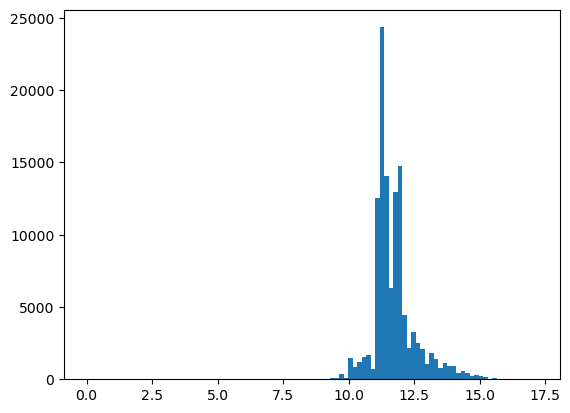

In [4]:
plt.figure()
plt.hist(y.numpy(), bins=100)
plt.show()

In [5]:
train_mask = torch.rand(x.shape[0]) < 0.8
x_train = x[train_mask]
y_train = y[train_mask]

x_test = x[~train_mask]
y_test = y[~train_mask]

# z score y 
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

print('# train', x_train.shape[0])
print('# test', x_test.shape[0])

# train 94542
# test 23712


In [6]:
mlp_kwargs = model_kwargs={'hidden_channels':100, 
                           'layers'         :4}

hnet_kwargs = {'stochastic_channels':4, 
               'width'              :256}

model, losses = train_hnet(x_train,
                           y_train, 
                           mlp_kwargs, 
                           hnet_kwargs, 
                           loss_fn='edl', 
                           lr=5e-4, 
                           batch_size=5000, 
                           num_epochs=100, 
                           nsamples=200, 
                           compile=False, 
                           use_cuda=True, 
                           pretrain_init=False)

torch.save(model, 'model.pt')

In [7]:
model = model.cuda()
yhat_test = [] 
with torch.no_grad():
    for i in range(0, x_test.shape[0], 1024):
        yhat_test.append(model(x_test[i:i+1024].cuda(), samples=2000).cpu())
yhat_test = torch.cat(yhat_test, dim=1)
yhat_test.shape

torch.Size([2000, 23712, 1])

In [8]:
## prev : 0.6957550558658843 0.4816768169403076 - with nll 
## 0.7678886460529332 0.5890097618103027 - edl, works well!0.8149173203966256 0.6624746322631836
r = np.corrcoef(y_test.numpy().ravel(), yhat_test.mean(dim=0).numpy().ravel())[0, 1]
r2 = r2_score(y_test.numpy().ravel(), yhat_test.mean(dim=0).numpy().ravel())
print(r, r2)

0.6005003773899635 0.33722203969955444


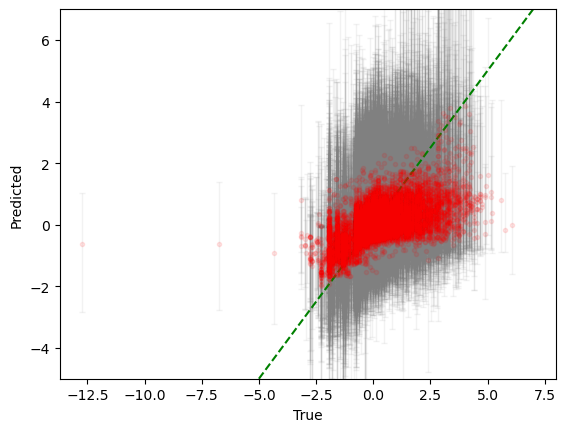

In [9]:
ql = 0.025
qu = 0.975
yhat_lower = yhat_test.quantile(ql, dim=0).squeeze().numpy()
yhat_upper = yhat_test.quantile(qu, dim=0).squeeze().numpy()
yhat_mean = yhat_test.mean(dim=0).squeeze().numpy()

plt.figure()
plt.errorbar(y_test.numpy(), yhat_mean, yerr=[yhat_mean - yhat_lower, yhat_upper - yhat_mean], fmt='r.', alpha=0.1, ecolor='gray', elinewidth=1, capsize=2)
plt.plot((-5, 7), (-5, 7), 'g--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.ylim(-5, 7)
plt.show()

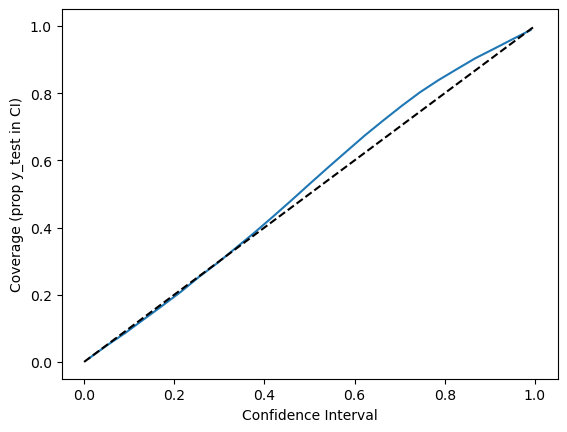

In [10]:
prop = []; cii = []
for ci in np.linspace(0.01, 0.99, 25):
    cii.append(ci)
    ql = (1-ci)/2
    qu = 1 - ql 
    lcb, ucb = yhat_test.quantile(torch.tensor([ql, qu], dtype=torch.float32), dim=0)
    prop.append( ((y_test > lcb) & (y_test < ucb)).float().mean() ) 

plt.figure()
plt.plot(cii, prop)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Confidence Interval')
plt.ylabel('Coverage (prop y_test in CI)')
plt.show()

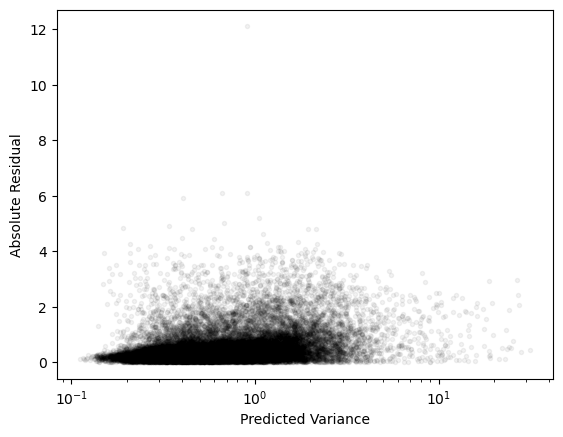

In [11]:
resid = y_test.numpy().ravel() - yhat_test.mean(dim=0).numpy().ravel()
pred_var = yhat_test.var(dim=0).numpy().ravel()

plt.figure()
plt.plot(yhat_test.var(dim=0).numpy(), np.abs(resid), 'k.', alpha=0.05)
plt.xlabel('Predicted Variance')
plt.ylabel('Absolute Residual')
plt.xscale('log')
plt.show()
